In [1]:
# active_config.py
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from app.config import get_config, update_config
from app.model_development import ConvAE_model_subclass
from tensorflow.keras.models import load_model
from app.helper_functions import metric_satisfaction_ratio
from app.metrics import calculate_consistency_metric
from app.feature_preprocessing import feature_preprocessing, features_ene_rul_train

SETUP = "pronostia"         # "pronostia or XJTU_SY"
Local = True                # True=local, False=remote

if not Local:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["NUMEXPR_MAX_THREADS"] = "32"
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

# Get the base config for the chosen setup
cfg = get_config(setup_name=SETUP, Local=Local)

# Apply dynamic update immediately
update_config(cfg, bearing_used='Bearing1')
 
# ======== Update the rescale factors of the constraints ========= #
cfg.constraint_params.soft_rank_rf = 1.0
cfg.constraint_params.monotonicity_rf = (0.0, 0.0)
cfg.constraint_params.energy_hi_dev_rf = 1.5
cfg.constraint_params.upper_bound_rf = 2.0
cfg.constraint_params.lower_bound_rf = 2.0

2025-07-25 10:07:46.170384: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 10:07:46.241877: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-25 10:07:46.434561: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-25 10:07:46.730751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753427266.988762   12983 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753427267.06

In [2]:
# ====================== LOAD the FEATURES ===================== #

# Create the preprocessing class!
print("Initializing feature preprocessing...")
feature_preprocess = feature_preprocessing(cfg.FEATURE_DIR,
                                           cfg.OUTPUT_DIR,
                                           cfg.bearing_used,
                                           cfg.channel)

# Load the features!
print("Loading mel features...")
feature_db_list = feature_preprocess.load_mel_features(cfg.n_mels)

# Split and scale the features!
train_index_list = cfg.bearing_splits[cfg.bearing_used]["train_index"]
test_index_list = cfg.bearing_splits[cfg.bearing_used]["test_index"]
print(f"Splitting and scaling features. "
            f"Train Indexes: {train_index_list}, Test Indexes: {test_index_list}...")
X_train, X_test, X_train_scaled, X_test_scaled = feature_preprocess.split_scale_features(
    feature_db_list, train_index_list, test_index_list)

# Extract the scaled energy, RUL and order of both the training and test samples!
print("Calculating the feature energy for both training and test...")
Ene_RUL_order_train = features_ene_rul_train(X_train)
Ene_RUL_order_test = features_ene_rul_train(X_test)

Initializing feature preprocessing...
Loading mel features...
Splitting and scaling features. Train Indexes: [0, 1], Test Indexes: [2, 3, 4, 5, 6]...
Calculating the feature energy for both training and test...


Iteration 0: Model performance stabilized after 73 epochs.
Iteration 1: Model performance stabilized after 57 epochs.
Iteration 2: Model performance stabilized after 81 epochs.
Iteration 3: Model performance stabilized after 90 epochs.
Iteration 4: Model performance stabilized after 80 epochs.
Iteration 5: Model performance stabilized after 89 epochs.
Iteration 6: Model performance stabilized after 83 epochs.
Iteration 7: Model performance stabilized after 138 epochs.
Iteration 8: Model performance stabilized after 64 epochs.


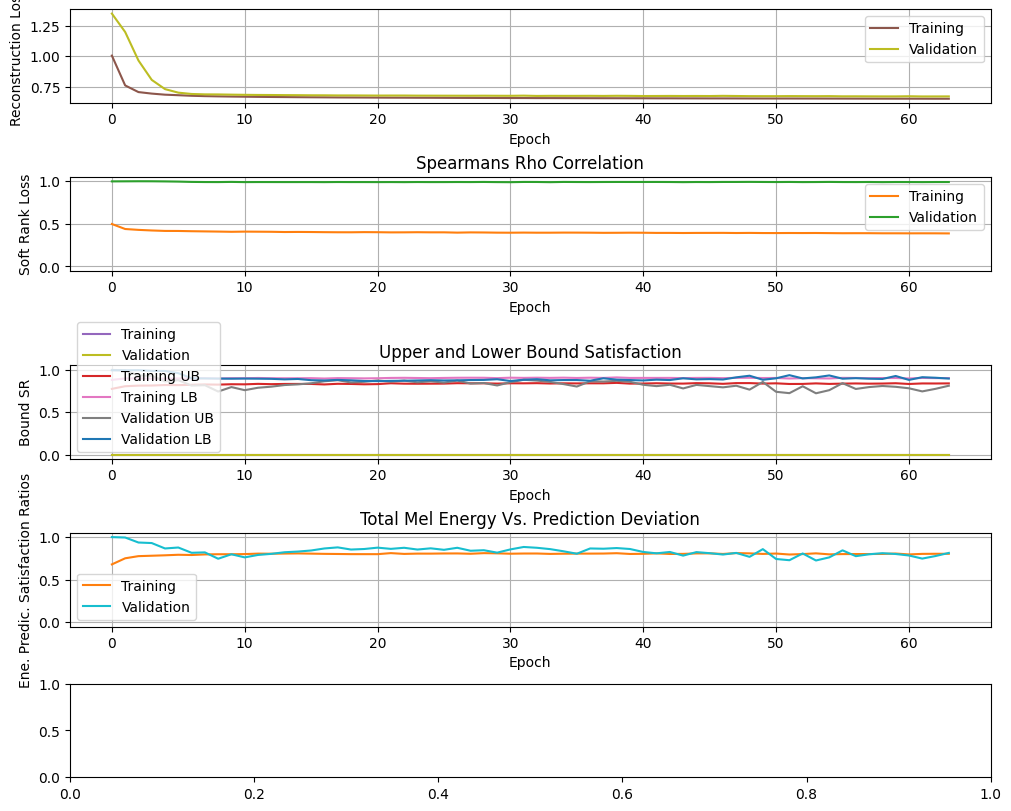

In [3]:
# ======== Load Constraint Satisfaction Ratios!  =========== #

# number_of_iter = cfg.model_training_params.training_iterations
number_of_iter = 9

for iter_n in range(number_of_iter):
    filename = f'performance_df_' \
               f'{cfg.model_hyperparams.encoding_n}_' \
               f'{cfg.SETUP_Name}_' \
               f'{cfg.bearing_used}_' \
               f'{cfg.constraint_params.reconstruction_rf}_' \
               f'{cfg.constraint_params.soft_rank_rf}_' \
               f'{cfg.constraint_params.monotonicity_rf[1]}_' \
               f'{cfg.constraint_params.energy_hi_dev_rf}_' \
               f'{cfg.constraint_params.upper_bound_rf}_' \
               f'{cfg.constraint_params.lower_bound_rf}_' \
               f'{iter_n}.pkl'
    model_per_dir = os.path.join(cfg.OUTPUT_DIR, "models_performance")
    full_path = os.path.join(model_per_dir, filename)

    model_sat_R_results = pd.read_pickle(full_path)
    print(f"Iteration {iter_n}: Model performance stabilized after {len(model_sat_R_results)} epochs.")

    # if iter_n == 0:
    #     model_sat_R_results.info()

epoches = np.arange(0, len(model_sat_R_results))

fig, axs = plt.subplots(5, 1, layout='constrained', figsize=(10, 8))


axs[0].plot(epoches, model_sat_R_results['train_reconstruction_loss_epoch'], 'C5', label='Training')
axs[0].plot(epoches, model_sat_R_results['val_reconstruction_loss_epoch'], 'C8', label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Reconstruction Loss')
# axs[0].axis(ymin=-0.05, ymax=1.05)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(epoches, model_sat_R_results['train_soft_rank_loss_epoch'], 'C1', label='Training')
axs[1].plot(epoches, model_sat_R_results['val_soft_rank_loss_epoch'], 'C2', label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Soft Rank Loss')
# axs[1].set_title('Soft Rank Loss')
axs[1].axis(ymin=-0.05, ymax=1.05)
axs[1].grid(True)
axs[1].legend()

axs[2].plot(epoches, model_sat_R_results['train_mono_corr_epoch'], 'C4', label='Training')
axs[2].plot(epoches, model_sat_R_results['val_mono_corr_epoch'], 'C8', label='Validation')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Monotonicity')
axs[1].set_title('Spearmans Rho Correlation')
axs[1].axis(ymin=-0.05, ymax=1.05)
axs[1].grid(True)
axs[1].legend()

axs[2].plot(epoches, model_sat_R_results['train_upper_bnd_sat_epoch'], 'C3', label='Training UB')
axs[2].plot(epoches, model_sat_R_results['train_lower_bnd_sat_epoch'], 'C6', label='Training LB')
axs[2].plot(epoches, model_sat_R_results['val_upper_bnd_sat_epoch'], 'C7', label='Validation UB')
axs[2].plot(epoches, model_sat_R_results['val_lower_bnd_sat_epoch'], 'C10', label='Validation LB')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Bound SR')
axs[2].set_title('Upper and Lower Bound Satisfaction')
axs[2].axis(ymin=-0.05, ymax=1.05)
axs[2].grid(True)
axs[2].legend()

axs[3].plot(epoches, model_sat_R_results['train_ene_pred_deviation_epoch'], 'C11', label='Training')
axs[3].plot(epoches, model_sat_R_results['val_ene_pred_deviation_epoch'], 'C9', label='Validation')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Ene. Predic. Satisfaction Ratios')
axs[3].set_title('Total Mel Energy Vs. Prediction Deviation')
axs[3].axis(ymin=-0.05, ymax=1.05)
axs[3].grid(True)
axs[3].legend()   

In [4]:
# ===========    Model architecture!!   ======== #
input_sh = cfg.model_hyperparams.input_sample_shape
encod_n = cfg.model_hyperparams.encoding_n
regularization = cfg.model_hyperparams.regularization
dropout_rate = cfg.model_hyperparams.dropout_rate
poolsize = cfg.model_hyperparams.pooling_size
kernelsize = cfg.model_hyperparams.kernel_size_conv
stride = cfg.model_hyperparams.stride_conv
activation = cfg.model_hyperparams.activation_function

model_weight_dir = os.path.join(cfg.OUTPUT_DIR, "model_weights")

entries = train_index_list + test_index_list
br_mel_fs = X_train_scaled + X_test_scaled
br_ene_RUL_order = Ene_RUL_order_train + Ene_RUL_order_test

# (Re)initialize the model inside the loop!
model_instance = ConvAE_model_subclass(
    input_shape=input_sh,
    encoding_neurons=encod_n,
    reg=regularization,
    dropout=dropout_rate,
    poolsize=poolsize,
    kernelsize=kernelsize,
    stride=stride,
    activation=activation
)

# Build the model by calling with dummy input (MANDATORY before loading weights)
model_instance(tf.zeros((1, input_sh[0], input_sh[1]), dtype=tf.float32))
model_instance.model().summary()  

E0000 00:00:1753427322.352056   12983 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753427322.359660   12983 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 256)  │      2,816 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 8, 16)     │          0 │ sequential[0][0], │
│ (MaxPooling1D)      │                   │            │ sequential_1[0][… │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 32)    │     24,736 │ max_pooling1d[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32)    │      3,232 │ max_pooling1d[1]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16)    │      1,616 │ max_pooling1d[2]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ max_pooling1d[3]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      2,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 16)     │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16)    │        848 │ reshape[0][0]     │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 32, 32)    │      1,696 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 32)    │      3,232 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 128, 256)  │     25,856 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 1)         │      1,361 │ dense[0][0]       │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dec_out (Conv1D)    │ (None, 128, 2)    │      1,538 │ sequential_8[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71,171 (278.01 KB)

 Trainable params: 69,827 (272.76 KB)

 Non-trainable params: 1,344 (5.25 KB)

In [ ]:
############### Model Performance Evaluation!!!! #################

Mono1_all = np.zeros((number_of_iter, len(entries)))
Mono2_all = np.zeros((number_of_iter, len(entries)))
Robustness_all = np.zeros((number_of_iter, len(entries)))
Trendability1_all = np.zeros((number_of_iter, len(entries)))
Trendability2_all = np.zeros((number_of_iter, len(entries)))

RUL_Pred_all = []

for i in range(number_of_iter):
    # (Re)initialize the model inside the loop!
    model_instance = ConvAE_model_subclass(
        input_shape=input_sh,
        encoding_neurons=encod_n,
        reg=regularization,
        dropout=dropout_rate,
        poolsize=poolsize,
        kernelsize=kernelsize,
        stride=stride,
        activation=activation
    )
    
    # Build the model by calling with dummy input (MANDATORY before loading weights)
    model_instance(tf.zeros((1, input_sh[0], input_sh[1]), dtype=tf.float32))
    
    # load the weights!
    final_filename = os.path.join(
        model_weight_dir,
        f"Custom_Model_{cfg.model_hyperparams.encoding_n}_" 
        f"{cfg.SETUP_Name}_"
        f"{cfg.bearing_used}_{cfg.constraint_params.reconstruction_rf}_"
        f"{cfg.constraint_params.soft_rank_rf}_"
        f"{cfg.constraint_params.monotonicity_rf[1]}_"
        f"{cfg.constraint_params.energy_hi_dev_rf}_"
        f"{cfg.constraint_params.upper_bound_rf}_"
        f"{cfg.constraint_params.lower_bound_rf}_{i}_recon_val.h5"
    )
    
    model_instance = load_model(final_filename, compile=False)
    print('Model '+ str(i+1) + ' Performance!')
    
    for j in range(len(entries)):
        index =  entries.index(j)
        Input_Data = br_mel_fs[index]
        RUL_Pred, _, _ = model_instance.predict(Input_Data, verbose=0)
        
        RUL_Pred_new = RUL_Pred.reshape(-1)

        RUL_Pred_all.append(RUL_Pred_new)
        
        _, Mono1, Mono2, Robustness, Trendability1, Trendability2 = metric_satisfaction_ratio(
            predictions = RUL_Pred_new, 
            tau = 0.025)
        
        Mono1_all[i, j] = Mono1
        Mono2_all[i, j] = Mono2
        Robustness_all[i, j] = Robustness
        Trendability1_all[i, j] = Trendability1
        Trendability2_all[i, j] = Trendability2
        print(round(Robustness, 3), '\t\t', round(Trendability2, 3))
        
print('Mean and std Model Performance!')
# Mono1_all_mean = np.round(np.mean(Mono1_all, axis=0), 3)
# Mono1_all_std = np.round(np.std(Mono1_all, axis=0), 3)
# print('Monotonicity1: ', Mono1_all_mean, '+-', Mono1_all_std)
# Mono2_all_mean = np.round(np.mean(Mono2_all, axis=0), 3)
# Mono2_all_std = np.round(np.std(Mono2_all, axis=0), 3)
# print('Monotonicity2: ', Mono2_all_mean, '+-', Mono2_all_std)
Robustness_all_mean = np.round(np.mean(Robustness_all, axis=0), 3)  
Robustness_all_std = np.round(np.std(Robustness_all, axis=0), 3) 
print('Robustness: ', Robustness_all_mean, '+-', Robustness_all_std)
# Trendability1_all_mean = np.round(np.mean(Trendability1_all, axis=0), 3)
# Trendability1_all_std = np.round(np.std(Trendability1_all, axis=0), 3)
# print('Trendability1: ', Trendability1_all_mean, '+-', Trendability1_all_std)
Trendability2_all_mean = np.round(np.mean(Trendability2_all, axis=0), 3)
Trendability2_all_std = np.round(np.std(Trendability2_all, axis=0), 3)
print('Trendability2: ', Trendability2_all_mean, '+-', Trendability2_all_std)

Model 1 Performance!


In [7]:
############### Consistency Metric Performance Evaluation!!!! #################
entries = train_index_list + test_index_list
br_mel_fs = X_train_scaled + X_test_scaled
br_ene_RUL_order = Ene_RUL_order_train + Ene_RUL_order_test

consistency_score_mean_all, consistency_score_std_all = [], []
RUL_Pred_all = []
for j in range(len(entries)):
    index =  entries.index(j)
    Input_Data = br_mel_fs[index]
    RUL_Pred_Iter = []
    print('Bearing '+ str(j+1) + ' Performance!')
    for i in range(number_of_iter):
        # load the weights!
        final_filename = os.path.join(
            model_weight_dir,
            f"Custom_Model_{cfg.model_hyperparams.encoding_n}_" 
            f"{cfg.SETUP_Name}_"
            f"{cfg.bearing_used}_{cfg.constraint_params.reconstruction_rf}_"
            f"{cfg.constraint_params.soft_rank_rf}_"
            f"{cfg.constraint_params.monotonicity_rf[1]}_"
            f"{cfg.constraint_params.energy_hi_dev_rf}_"
            f"{cfg.constraint_params.upper_bound_rf}_"
            f"{cfg.constraint_params.lower_bound_rf}_{i}_recon_val.h5"
        )

        model_instance = load_model(final_filename, compile=False)
        
        RUL_Pred, _, _ = model_instance.predict(Input_Data, verbose=0)
        RUL_Pred_new = RUL_Pred.reshape(-1)
        RUL_Pred_Iter.append(RUL_Pred_new)
    RUL_Pred_all.append(np.transpose(np.array(RUL_Pred_Iter)))
    consistency_score_mean, consistency_score_std = calculate_consistency_metric(np.transpose(np.array(RUL_Pred_Iter)))
    consistency_score_mean_all.append(consistency_score_mean)
    consistency_score_std_all.append(consistency_score_std)

consistency_scores_mean = np.round(np.array(consistency_score_mean_all), 3)
consistency_scores_std = np.round(np.array(consistency_score_std_all), 3)
print('Consistency: ', consistency_scores_mean, '+-', consistency_scores_std)

Bearing 1 Performance!
Bearing 2 Performance!
Bearing 3 Performance!
Bearing 4 Performance!
Bearing 5 Performance!
Bearing 6 Performance!
Bearing 7 Performance!
Consistency:  [0.96  0.917 0.973 0.99  0.936 0.984 0.977] +- [0.033 0.075 0.025 0.008 0.055 0.011 0.017]


Monotonicity1 	 Monotonicity2 	 Robustness 	 Trendibility1 	 Trendibility2
0.002 		 0.502 		 0.944 		 -0.743 		 -0.995
0.037 		 0.508 		 0.943 		 -0.611 		 -0.968
0.002 		 0.51 		 0.893 		 -0.401 		 -0.393
-0.005 		 0.505 		 0.899 		 -0.764 		 -0.758
-0.007 		 0.502 		 0.98 		 -0.552 		 -0.65
0.005 		 0.501 		 0.97 		 -0.695 		 -0.72
0.004 		 0.501 		 0.971 		 -0.323 		 -0.263


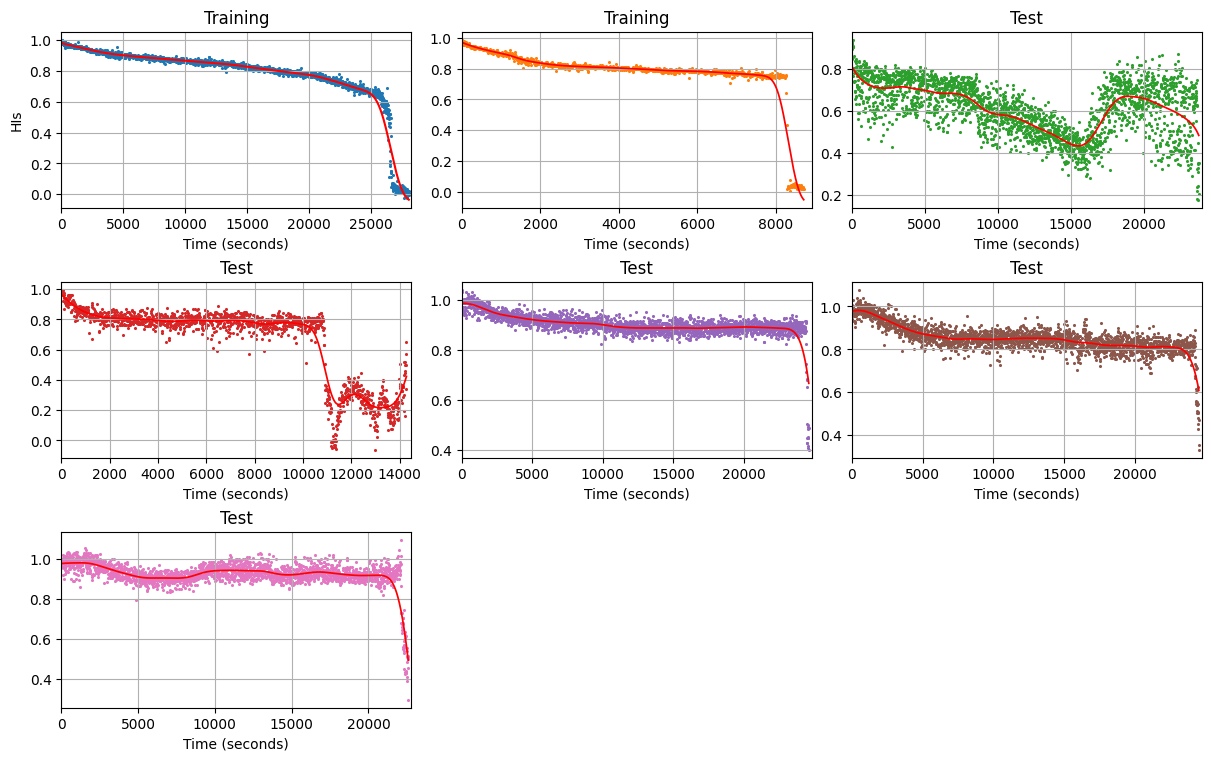

In [5]:
####### Plot the predictions! ###############
import math
from app.metrics import lowess

i = 0

# load the weights!
final_filename = os.path.join(
    model_weight_dir,
    f"Custom_Model_{cfg.model_hyperparams.encoding_n}_" 
    f"{cfg.SETUP_Name}_"
    f"{cfg.bearing_used}_{cfg.constraint_params.reconstruction_rf}_"
    f"{cfg.constraint_params.soft_rank_rf}_"
    f"{cfg.constraint_params.monotonicity_rf[1]}_"
    f"{cfg.constraint_params.energy_hi_dev_rf}_"
    f"{cfg.constraint_params.upper_bound_rf}_"
    f"{cfg.constraint_params.lower_bound_rf}_{i}_recon_val.h5"
)

model_instance = tf.keras.models.load_model(final_filename, compile=False)

# ================ Visualize the signal ================== #
rows, column = math.ceil((len(entries)+1)/3), 3
# fig, axs = plt.subplots(nrows=rows, ncols=column, figsize=(14.0, 4.0), constrained_layout = True)
fig, axs = plt.subplots(nrows=rows, ncols=column, figsize=(4*column, 2.5*rows), constrained_layout = True)
# Define colormap and color range
cmap = plt.cm.tab10  # Choose a colormap

print('Monotonicity1 \t', 'Monotonicity2 \t', 'Robustness \t', 'Trendibility1 \t', 'Trendibility2')

for i in range(rows):
    for j in range(column):
        if i*column + j < len(entries):  # Check if there is more data to plot
            index =  entries.index(i*column + j)
            Input_Data = br_mel_fs[index]
            RUL_Pred, _, _ = model_instance.predict(Input_Data, verbose=0)
            
            # RUL_Pred_new = np.insert(RUL_Pred, 0, np.full(n_timesteps, RUL_Pred[0]))
            RUL_Pred_new = RUL_Pred.reshape(-1)
            time_values1 = np.linspace(0, len(RUL_Pred_new)*10, len(RUL_Pred_new))
            smoothed_RUL = lowess(time_values1, RUL_Pred_new, tau=0.025)
            
            _, Mono1, Mono2, Robustness, Trendability1, Trendability2 = metric_satisfaction_ratio(
                predictions = RUL_Pred_new, 
                tau = 0.025)
            
            print(round(Mono1, 3), '\t\t', round(Mono2, 3), '\t\t', round(Robustness, 3), '\t\t', 
                  round(Trendability1, 3), '\t\t', round(Trendability2, 3))
       
            if i*column + j in train_index_list:
                if j == 0:
                    axs[i, j].scatter(time_values1, RUL_Pred_new, s=1.5, color=cmap(i * column + j), label='HIs')
                    axs[i, j].plot(time_values1, smoothed_RUL, color='r')
                    axs[i, j].set_title('Training')
                    axs[i, j].set_xlabel('Time (seconds)')
                    axs[i, j].set_ylabel('HIs')
                else:
                    axs[i, j].scatter(time_values1, RUL_Pred_new, s=1.5, color=cmap(i * column + j))
                    axs[i, j].plot(time_values1, smoothed_RUL, color='r', linewidth=1.25)
                    axs[i, j].set_title('Training')
                    axs[i, j].set_xlabel('Time (seconds)')
            else:
                axs[i, j].scatter(time_values1, RUL_Pred_new, s=1.5, color=cmap(i * column + j))
                axs[i, j].plot(time_values1, smoothed_RUL, color='r', linewidth=1.25)
                axs[i, j].set_title('Test')
                axs[i, j].set_xlabel('Time (seconds)')
            axs[i, j].axis(xmin=0, xmax=len(RUL_Pred_new)*10+200)
            # axs[i, j].axis(ymin=-0.05, ymax=1.1)
            axs[i, j].grid(True)
        else:
            # Remove any extra subplots
            fig.delaxes(axs[i, j])

# # # Save the plot!
# plt.savefig('Plots/SRAE_setup3_HIs.png', format='png', dpi=300)  # Save as PNG
# plt.savefig('Plots/SRAE_setup3_HIs.pdf', format='pdf', dpi=300)  # Save as PDF
plt.show()